In [1]:
import glob
import json
import os

import re
from collections import Counter, defaultdict

from datetime import datetime
from operator import itemgetter, methodcaller
import time

import itertools
import requests
from tqdm import tqdm
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

In [3]:
res1 = r"(<[^>]*>)"
res2 = r"(-(\n|\r|\r\n|\x0b|\x0c|\x1c|\x1d|\x1e|\x85|\u2028|\u2029))"
com1 = re.compile(res1, re.IGNORECASE)
com2 = re.compile(res2, re.IGNORECASE)
task_name = 'any2txt|wcrft2|liner2({"model":"n82"})'
url = 'http://ws.clarin-pl.eu/nlprest2/base'
res_path = 'data/result'

In [4]:
def json_file():
    for name in ("judgments-1571.json", "judgments-1572.json"):
        with open(os.path.join("data", "json", name), "r") as f:
            yield json.load(f)

def given_date(date):
    z = datetime.strptime(date, '%Y-%m-%d')
    return z.year == 2015

def sort_by_date():
    res = []
    for file in tqdm(json_file()):
        for y in file['items']:
            if given_date(y['judgmentDate']):
                res.append(y)
    res.sort(key=itemgetter('judgmentDate'))
    return res[:100]

In [5]:
def process(data):
    ids = requests.post('{}/upload/'.format(url), data=data.encode('utf-8'),
                        headers={'Content-Type': 'binary/octet-stream'}
                        ).text
    task = requests.post(url='{}/startTask/'.format(url),
                         json={'lpmn': task_name, 'file': ids, 'user': ''},
                         headers={'Content-Type': 'application/json'}
                         ).text

    status = requests.get(url='{}/getStatus/{}'.format(url, task)).json()
    while status['status'] in ('QUEUE', 'PROCESSING'):
        time.sleep(1)
        tqdm.write(status['status'])
        status = requests.get(url='{}/getStatus/{}'.format(url, task)).json()

    if status['status'] == 'DONE' and status['value']:
        processed = status['value'][0]['fileID']
        tqdm.write(status['status'])
        return requests.get(url='{}/download{}'.format(url, processed)).text

    elif status['status'] == 'ERROR':
        tqdm.write(status['status'])
        tqdm.write('Error: ', status['value'])

In [6]:
def from_files(paths):
    for name in glob.glob(os.path.join(paths, "*")):
        with open(name, "r") as f:
            tree = ET.parse(f)
        yield from tree.getroot().iter("tok")

In [7]:
def start_proccess():
    res = sort_by_date()
    i = 0
    for y in tqdm(res):
        done = process(com2.sub("", com1.sub("", y['textContent'])))
        if done:
            with open(os.path.join(res_path, str(i)), "w") as f:
                f.write(done)
        i += 1

In [22]:
left, right = itertools.tee(map(lambda t: t.attrib['chan'], 
                                itertools.chain.from_iterable(map(methodcaller('findall', "ann"), 
                                                                  from_files(res_path)))))

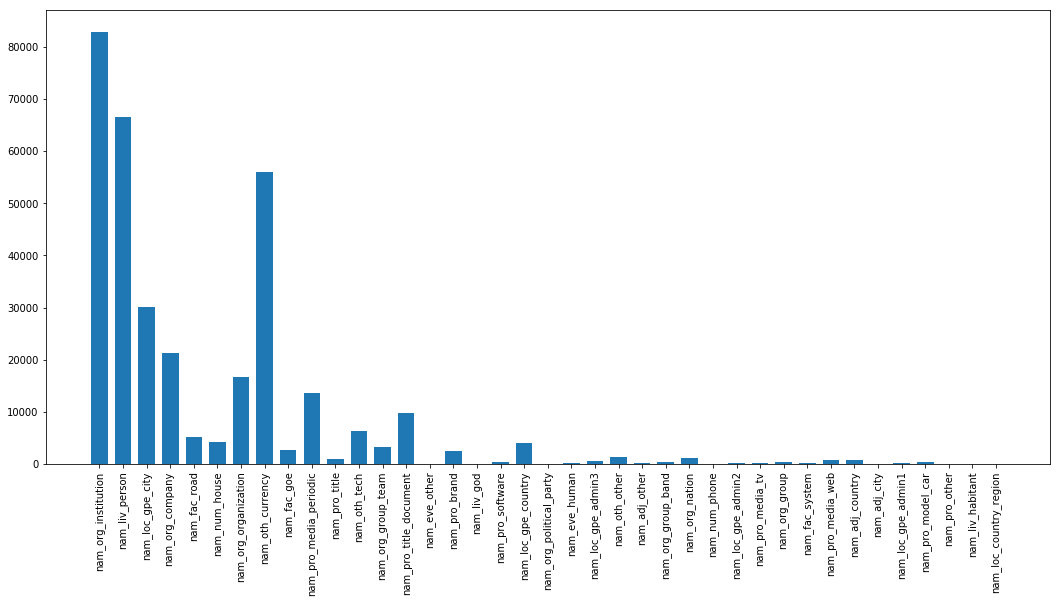

In [23]:
plt.figure(figsize=(18,10))
labels, values = zip(*Counter(right).items())
width = 0.7
indexes = np.arange(len(labels))

plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation='vertical')
plt.subplots_adjust(bottom=0.25)
plt.show()

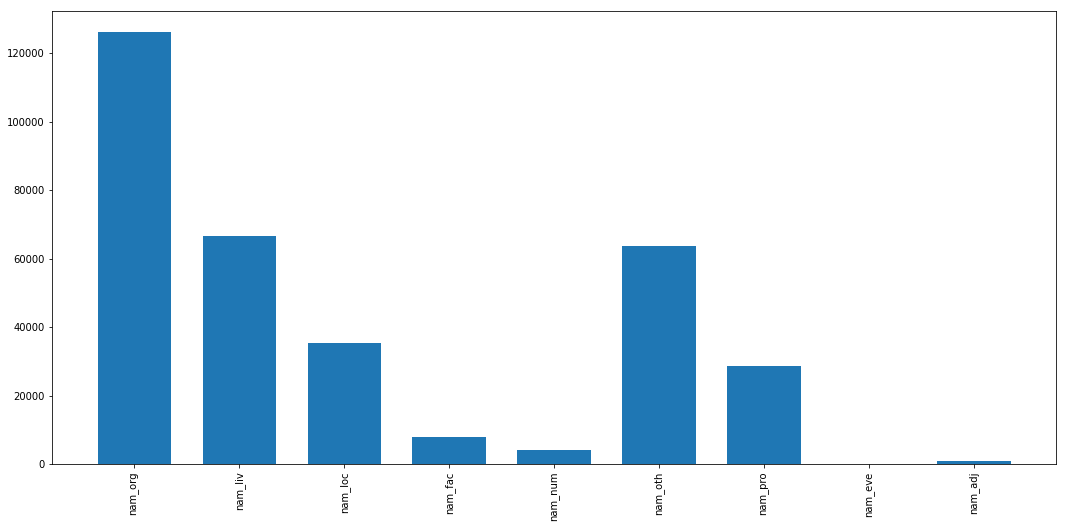

In [24]:
plt.figure(figsize=(18,10))
labels, values = zip(*Counter(map(lambda x: x[:x.find("_", x.find("_")+1)], left)).items())
indexes = np.arange(len(labels))
plt.bar(indexes, values, width)
plt.xticks(indexes, labels, rotation='vertical')
plt.subplots_adjust(bottom=0.25)
plt.show()

In [21]:
seeds = Counter(map(lambda k: (k[0].text, k[1].attrib['chan']),
                    filter(lambda m: m[1] is not None, 
                           map(lambda t: (t.find("orth"), t.find('ann')), from_files(res_path)))))
print('\n'.join(map(lambda k: f"\033[1m{k[0][0]}\033[0m -> {k[0][1]}: {k[1]}", seeds.most_common(100))))

. -> nam_liv_person: 6476
. -> nam_org_institution: 6163
. -> nam_oth_currency: 4217
, -> nam_org_institution: 2840
w -> nam_org_institution: 2416
, -> nam_liv_person: 2394
, -> nam_oth_currency: 2250
. -> nam_org_company: 1642
w -> nam_liv_person: 1436
z -> nam_org_institution: 1422
. -> nam_org_organization: 1328
zł -> nam_oth_currency: 1265
) -> nam_liv_person: 1251
( -> nam_liv_person: 1241
w -> nam_oth_currency: 1108
z -> nam_liv_person: 957
. -> nam_loc_gpe_city: 931
) -> nam_oth_currency: 895
( -> nam_oth_currency: 857
( -> nam_org_institution: 827
na -> nam_org_institution: 819
) -> nam_org_institution: 800
. -> nam_oth_tech: 720
Sąd -> nam_org_institution: 701
. -> nam_pro_title_document: 686
1 -> nam_liv_person: 682
i -> nam_org_institution: 672
z -> nam_oth_currency: 654
i -> nam_liv_person: 641
na -> nam_oth_currency: 600
. -> nam_pro_media_periodic: 556
o -> nam_org_institution: 551
dnia -> nam_org_institution: 539
, -> nam_org_company: 536
k -> nam_org_institution: 530
na

In [18]:
mab = defaultdict(Counter)
for name, ort in map(lambda x: (x[1][:x[1].find("_", x[1].find("_")+1)], x[0]), map(lambda k: (k[0].text, k[1].attrib['chan']), filter(lambda m: m[1] is not None,
                                                               map(lambda t: (t.find("orth"), t.find('ann')),
                                                                   from_files(res_path))))):
    mab[name][ort] +=1
for a,b in mab.items():
    print(f"{a}: ", ' '.join(map(lambda y: y[0],b.most_common(10))))

nam_org:  . , w z ( ) na i o Sąd
nam_liv:  . , w ) ( z 1 i na M
nam_loc:  . w , z ) o ( na do i
nam_oth:  . , zł w ) ( z na - i
nam_fac:  . , w z ) ( i na do o
nam_pro:  . , w z ) ( o i r na
nam_eve:  . , w – do I ( ) r ”
nam_adj:  , . z w spółki że pozwana niemieckiej nie do
nam_num:  . k – - i to samo , D (
